In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

# TESTES DE HIPÓTESES SOBRE UMA MÉDIA POPULACIONAL(µ) A PARTIR DE UMA AMOSTRA ALEATÓRIA

# Função geral - Teste Z para uma média populacional (uma amostra)

In [69]:
import numpy as np
from scipy import stats
import math

def teste_z_uma_amostra(
    mu0,
    x=None,                 # dados brutos (lista/array)
    xbar=None,              # média amostral
    n=None,                 # tamanho da amostra
    sigma=None,             # desvio-padrão populacional (conhecido)
    s=None,                 # desvio-padrão amostral (usar só se n grande)
    alpha=0.05,
    alternativa="bilateral" # "bilateral", "esquerda", "direita"
):
    
    alternativa = alternativa.lower()
    assert alternativa in ("bilateral", "esquerda", "direita")

    # Determina x_media e n
    if x is not None:
        x = np.asarray(x, dtype=float)
        n = x.size
        xbar = float(np.mean(x))
        if sigma is None and s is None:
            s = float(np.std(x, ddof=1))
            
    else:
        assert xbar is not None and n is not None, "Forneça x (dados) ou xbar e n."
        if sigma is None and s is None:
            raise ValueError("Informe sigma (populacional) ou s (amostral, só se n grande).")

    desvio = float(sigma if sigma is not None else s)
    se = desvio / math.sqrt(n)

    z_calc = (xbar - mu0) / se

    # p-valor e valores críticos
    if alternativa == "bilateral":
        p_valor = 2 * stats.norm.sf(abs(z_calc))
        z_c = stats.norm.ppf(1 - alpha/2)
        decisao = "Rejeitar H0" if (abs(z_calc) > z_c) or (p_valor < alpha) else "Não rejeitar H0"
        return dict(z_calc=z_calc, z_c=z_c, p_valor=p_valor, decisao=decisao, xbar=xbar, n=n, se=se, desvio_usado=desvio)
    
    elif alternativa == "esquerda":
        p_valor = stats.norm.cdf(z_calc)
        z_c_esq = stats.norm.ppf(alpha)
        decisao = "Rejeitar H0" if (z_calc < z_c_esq) or (p_valor < alpha) else "Não rejeitar H0"
        return dict(z_calc=z_calc, z_c_esq=z_c_esq, p_valor=p_valor, decisao=decisao, xbar=xbar, n=n, se=se, desvio_usado=desvio)
    
    else:
        p_valor = stats.norm.sf(z_calc)
        z_c_dir = stats.norm.ppf(1 - alpha)
        decisao = "Rejeitar H0" if (z_calc > z_c_dir) or (p_valor < alpha) else "Não rejeitar H0"
        
        return dict(z_calc=z_calc, z_c_dir=z_c_dir, p_valor=p_valor, decisao=decisao, xbar=xbar, n=n, se=se, desvio_usado=desvio)

# Exemplo 8 — Teste Z para uma amostra (unilateral à esquerda)

Contexto: o fabricante afirma μ ≥ 4,2 g (σ conhecido = 1 g).  
A amostra (n = 42) apresentou média x̄ = 3,9 g. Nível de significância α = 5%.

Hipóteses (unilateral à esquerda):
- H0: μ = 4,2
- H1: μ < 4,2

Regra: rejeitar H0 se z_calc < z_{α} ou se p-valor < α.

In [70]:
mu0   = 4.2
xbar  = 3.9
sigma = 1.0
n     = 42
alpha = 0.05

res_z = teste_z_uma_amostra( mu0=mu0, xbar=xbar, n=n, sigma=sigma, alpha=alpha, alternativa="esquerda")

print(f"z_calc = {res_z['z_calc']:.4f}")
print(f"z_c_esq = {res_z['z_c_esq']:.4f}")
print(f"p-valor = {res_z['p_valor']:.4f}")
print("Decisão:", res_z["decisao"])

z_calc = -1.9442
z_c_esq = -1.6449
p-valor = 0.0259
Decisão: Rejeitar H0


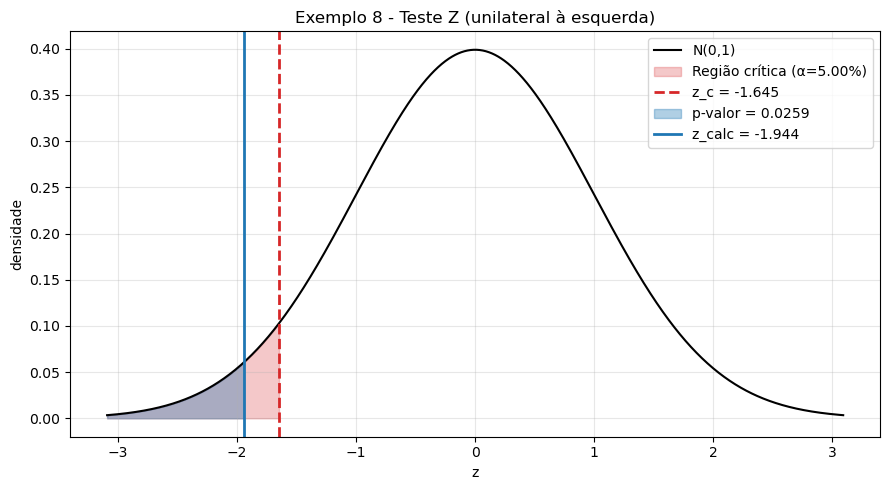

In [72]:
z_calc  = res_z['z_calc']
z_c_esq = res_z['z_c_esq']

x = np.linspace(stats.norm.ppf(0.001), stats.norm.ppf(0.999), 1200)
y = stats.norm.pdf(x)

plt.figure(figsize=(9,5))
plt.plot(x, y, color='black', lw=1.5, label="N(0,1)")

mask_alpha = x <= z_c_esq
plt.fill_between(x[mask_alpha], 0, y[mask_alpha], color='tab:red', alpha=0.25,
                 label=f"Região crítica (α={alpha:.2%})")
plt.axvline(z_c_esq, color='tab:red', ls='--', lw=2, label=f"z_c = {z_c_esq:.3f}")

p_valor = res_z['p_valor']
mask_p = x <= z_calc
plt.fill_between(x[mask_p], 0, y[mask_p], color='tab:blue', alpha=0.35,
                 label=f"p-valor = {p_valor:.4f}")
plt.axvline(z_calc, color='tab:blue', lw=2, label=f"z_calc = {z_calc:.3f}")

plt.title("Exemplo 8 - Teste Z (unilateral à esquerda)")
plt.xlabel("z")
plt.ylabel("densidade")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Função Geral para Testes de Hipóteses sobre uma média populacional com T de Student

## (Desvio padrão populacional não conhecido)

In [73]:
def teste_t(
    tipo="uma_amostra",                 # "uma_amostra" | "duas_independentes" | "emparelhadas"
    alternativa="bilateral",            # "bilateral" | "esquerda" | "direita"
    alpha=0.05,
    mu0=None,                           # média sob H0 (somente para "uma_amostra")
    x=None,                             # dados da amostra (uma_amostra)
    x1=None, x2=None,                   # dados dos dois grupos (independentes ou emparelhadas)
    caso=1                              # para "duas_independentes": 1 (σ1² ≠ σ2²) ou 2 (σ1² = σ2²)
):

    alternativa = alternativa.lower()
    assert alternativa in ("bilateral", "esquerda", "direita"), "alternativa inválida."

    if tipo == "uma_amostra":
        # Teste t para uma amostra (desvio-padrão populacional desconhecido)
        assert x is not None and mu0 is not None, "Forneça x e mu0."
        x = np.asarray(x, dtype=float)
        n = x.size
        X = x.mean()
        S = x.std(ddof=1)
        se = S / math.sqrt(n)
        T_calc = (X - mu0) / se
        gl = n - 1

    elif tipo == "duas_independentes":
        # Teste t para comparação de duas médias com amostras independentes
        assert x1 is not None and x2 is not None, "Forneça x1 e x2."
        x1 = np.asarray(x1, dtype=float)
        x2 = np.asarray(x2, dtype=float)
        n1, n2 = x1.size, x2.size
        X1, X2 = x1.mean(), x2.mean()
        S1, S2 = x1.std(ddof=1), x2.std(ddof=1)

        if caso == 1:
            # CASO 1: σ1² ≠ σ2²
            den = math.sqrt(S1**2/n1 + S2**2/n2)
            T_calc = (X1 - X2) / den
            num = (S1**2/n1 + S2**2/n2)**2
            den_gl = ((S1**2/n1)**2)/(n1-1) + ((S2**2/n2)**2)/(n2-1)
            gl = num / den_gl
            
        elif caso == 2:
            # CASO 2: σ1² = σ2²
            Sp2 = ((n1-1)*S1**2 + (n2-1)*S2**2) / (n1 + n2 - 2)
            Sp = math.sqrt(Sp2)
            T_calc = (X1 - X2) / (Sp * math.sqrt(1/n1 + 1/n2))
            gl = n1 + n2 - 2
            
        else:
            raise ValueError("caso deve ser 1 (σ1² ≠ σ2²) ou 2 (σ1² = σ2²)")

    elif tipo == "emparelhadas":
        assert x1 is not None and x2 is not None, "Forneça x1 (antes) e x2 (depois)."
        x1 = np.asarray(x1, dtype=float)
        x2 = np.asarray(x2, dtype=float)
        assert x1.size == x2.size, "Listas devem ter o mesmo tamanho."
        d = x1 - x2
        n = d.size
        d_bar = d.mean()
        Sd = d.std(ddof=1)
        se = Sd / math.sqrt(n)
        T_calc = d_bar / se
        gl = n - 1

    else:
        raise ValueError("tipo inválido.")

    if alternativa == "bilateral":
        p_valor = 2 * min(stats.t.cdf(T_calc, gl), 1 - stats.t.cdf(T_calc, gl))
        t_c = stats.t.ppf(1 - alpha/2, gl)  # t_{1−α/2, gl}
        
        decisao = "Rejeitar H0" if abs(T_calc) > t_c or p_valor < alpha else "Não rejeitar H0"
        
        resultado = dict(T_calc=T_calc, gl=gl, t_c=t_c, p_valor=p_valor, decisao=decisao)
        
    elif alternativa == "esquerda":
        p_valor = stats.t.cdf(T_calc, gl)   # P(T ≤ T_calc)
        t_c_esq = stats.t.ppf(alpha, gl)    # t_{α, gl}
        decisao = "Rejeitar H0" if (T_calc < t_c_esq) or (p_valor < alpha) else "Não rejeitar H0"
        
        resultado = dict(T_calc=T_calc, gl=gl, t_c_esq=t_c_esq, p_valor=p_valor, decisao=decisao)
        
    else:  # "direita"
        p_valor = 1 - stats.t.cdf(T_calc, gl)  # P(T ≥ T_calc)
        t_c_dir = stats.t.ppf(1 - alpha, gl)   # t_{1−α, gl}
        decisao = "Rejeitar H0" if (T_calc > t_c_dir) or (p_valor < alpha) else "Não rejeitar H0"
        
        resultado = dict(T_calc=T_calc, gl=gl, t_c_dir=t_c_dir, p_valor=p_valor, decisao=decisao)

    return resultado

# Exemplo 9
## Teste t de Student (uma amostra) — Verificar melhoria no tempo médio

Problema: Antes, o tempo médio era μ0 = 18 min. Após mudanças, coletou-se uma amostra (n = 25) com média x̄ = 16,808 min e desvio-padrão s = 2,733 min.  
Objetivo: Verificar, ao nível de significância α = 1%, se há evidência de melhoria (redução do tempo médio).

### Dados

Hipóteses (teste unilateral à esquerda):
- H0: μ = 18
- H1: μ < 18

- s = 2,733 min
- x̄ = 16,808

Por tratar-se de uma amostra com desvio-padrão populacional desconhecido, utilizaremos o teste t de Student.

Estatística de teste:
t_cal = (x̄ − μ0) / (s / √n), com gl = n − 1

Regra de decisão (unilateral à esquerda):
- Rejeitar H0 se t_cal < t_crit, onde t_crit = t_{α, gl}
- Equivalentemente, rejeitar H0 se p-valor < α

In [47]:
# Como o exemplo nao deu dados brutos, gerei uma amostra sintética que reproduz x̄, s e n
def sample_from_stats(n, mean, s):
    k = n // 2
    d = math.sqrt(((n - 1) * (s**2) * (n - k)) / (k * n))
    e = (k * d) / (n - k)
    a = mean - d
    b = mean + e
    return [a]*k + [b]*(n-k)

x_fake = sample_from_stats(n, xbar, s)

res9 = teste_t(tipo="uma_amostra", alternativa="esquerda", alpha=0.01, mu0=18.0, x=x_fake)
print(f"T_calc = {res9['T_calc']:.4f}, gl = {res9['gl']:.0f}, t_c_esq = {res9['t_c_esq']:.4f}, p-valor = {res9['p_valor']:.4f}")
print("Decisão:", res9["decisao"])

T_calc = -2.1808, gl = 24, t_c_esq = -2.4922, p-valor = 0.0196
Decisão: Não rejeitar H0


## Interpretação

- Se t_calc for maior que t_crit (menos negativo) e/ou p-valor ≥ α, não rejeitamos H0 ao nível de 1%.  
- p-valor tende a ser próximo de 2%, logo:
  - Ao nível de 1% (α = 0,01): não há evidência suficiente de melhoria.
  - Ao nível de 5% (α = 0,05): haveria evidência de melhoria.

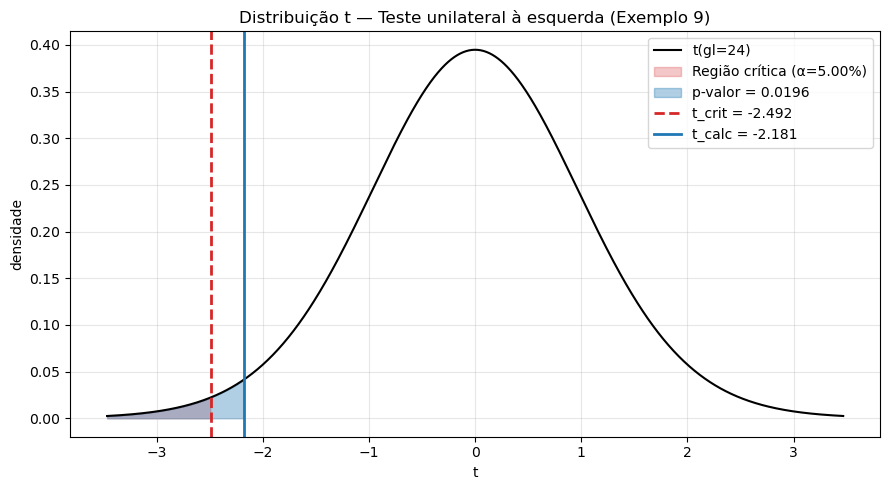

In [40]:
p_value = stats.t.cdf(t_calc, df)

x = np.linspace(stats.t.ppf(0.001, df), stats.t.ppf(0.999, df), 1000)
y = stats.t.pdf(x, df)

plt.figure(figsize=(9, 5))
plt.plot(x, y, color='black', lw=1.5, label=f"t(gl={df})")

mask_alpha = x <= t_crit
plt.fill_between(x[mask_alpha], 0, y[mask_alpha], color='tab:red', alpha=0.25, label=f"Região crítica (α={alpha:.2%})")

mask_p = x <= t_calc
plt.fill_between(x[mask_p], 0, y[mask_p], color='tab:blue', alpha=0.35, label=f"p-valor = {p_value:.4f}")

plt.axvline(t_crit, color='tab:red', ls='--', lw=2, label=f"t_crit = {t_crit:.3f}")
plt.axvline(t_calc, color='tab:blue', ls='-', lw=2, label=f"t_calc = {t_calc:.3f}")

plt.title("Distribuição t - Teste unilateral à esquerda (Exemplo 9)")
plt.xlabel("t")
plt.ylabel("densidade")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Exemplo 10 
## Teste t de Student para duas amostras independentes

Um engenheiro suspeita que o tempo médio de fabricação depende do fornecedor da matéria‑prima.  
Foram coletadas duas amostras independentes, com n1 = n2 = 30 observações (Fornecedor 1 e Fornecedor 2).

Objetivo: Ao nível de significância α = 5%, verificar se há diferença entre as médias.

## Hipóteses e escolha do teste

- H0: μ1 = μ2
- H1: μ1 ≠ μ2

## Fórmulas do teste

- CASO 1 (σ1² ≠ σ2²):
  - Estatística: T_calc = (X̄1 − X̄2) / sqrt(S1²/n1 + S2²/n2)
  
  - gl (ν): ν = (S1²/n1 + S2²/n2)² / [ (S1²/n1)²/(n1−1) + (S2²/n2)²/(n2−1) ]

- CASO 2 (σ1² = σ2²):
  - Variância combinada: S_p = sqrt( [ (n1−1)S1² + (n2−1)S2² ] / (n1 + n2 − 2) )
  
  - Estatística: T_calc = (X̄1 − X̄2) / [ S_p · sqrt(1/n1 + 1/n2) ]
  
  - gl: n1 + n2 − 2

Regra de decisão (bilateral):
- rejeitar H0 se |T_calc| > t_c, onde t_c = t_{1−α/2, gl}
- equivalente: rejeitar H0 se p-valor < α

In [22]:
alpha = 0.05

In [27]:
forn1 = [
    22.8, 23.4, 26.2, 24.3, 22.0, 24.8, 26.7, 25.1, 23.1, 22.8,
    25.6, 25.1, 24.3, 24.2, 22.8, 23.2, 24.7, 26.5, 24.5, 23.6,
    23.9, 22.8, 25.4, 26.7, 22.9, 23.5, 23.8, 24.6, 26.3, 22.7
]

forn2 = [
    26.8, 29.3, 28.4, 25.6, 29.4, 27.2, 27.6, 26.8, 25.4, 28.6,
    29.7, 27.2, 27.9, 28.4, 26.0, 26.8, 27.5, 28.5, 27.3, 29.1,
    29.2, 25.7, 28.4, 28.6, 27.9, 27.4, 26.7, 26.8, 25.6, 26.1
]

x1 = np.array(forn1, dtype=float)
x2 = np.array(forn2, dtype=float)

assert x1.size == 30 and x2.size == 30, "Informe 30 valores em cada lista."
n1, n2 = x1.size, x2.size

In [74]:
# função para plotar os gráficos

def plot_t_bilateral(T_calc, df, alpha, titulo):
    x = np.linspace(stats.t.ppf(0.001, df), stats.t.ppf(0.999, df), 1200)
    y = stats.t.pdf(x, df)
    t_c = stats.t.ppf(1 - alpha/2, df)
    p_bi = 2 * min(stats.t.cdf(T_calc, df), 1 - stats.t.cdf(T_calc, df))
    t_abs = abs(T_calc)

    plt.figure(figsize=(9,5))
    plt.plot(x, y, color='black', lw=1.5, label=f"t(gl={df:.2f})")

    mask_left_c = x <= -t_c
    mask_right_c = x >= t_c
    plt.fill_between(x[mask_left_c], 0, y[mask_left_c], color='tab:red', alpha=0.25, label=f"Regiões críticas (α={alpha:.2%})")
    plt.fill_between(x[mask_right_c], 0, y[mask_right_c], color='tab:red', alpha=0.25)

    mask_left_p = x <= -t_abs
    mask_right_p = x >= t_abs
    plt.fill_between(x[mask_left_p], 0, y[mask_left_p], color='tab:blue', alpha=0.35, label=f"p-valor = {p_bi:.4f}")
    plt.fill_between(x[mask_right_p], 0, y[mask_right_p], color='tab:blue', alpha=0.35)

    plt.axvline(-t_c, color='tab:red', ls='--', lw=2, label=f"± t_c = {t_c:.3f}")
    plt.axvline(t_c, color='tab:red', ls='--', lw=2)
    plt.axvline(T_calc, color='tab:blue', ls='-', lw=2, label=f"T_calc = {T_calc:.3f}")

    plt.title(titulo)
    plt.xlabel("t")
    plt.ylabel("densidade")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## CASO 1 — σ1² ≠ σ2²

In [48]:
res10_c1 = teste_t(tipo="duas_independentes", alternativa="bilateral", alpha=alpha, x1=forn1, x2=forn2, caso=1)

print(f"T_calc = {res10_c1['T_calc']:.4f}, gl ≈ {res10_c1['gl']:.2f}, t_c = {res10_c1['t_c']:.4f}, p-valor = {res10_c1['p_valor']:.4f}")
print("Decisão:", res10_c1["decisao"])

T_calc = -9.7084, gl ≈ 57.68, t_c = 2.6638, p-valor = 0.0000
Decisão: Rejeitar H0


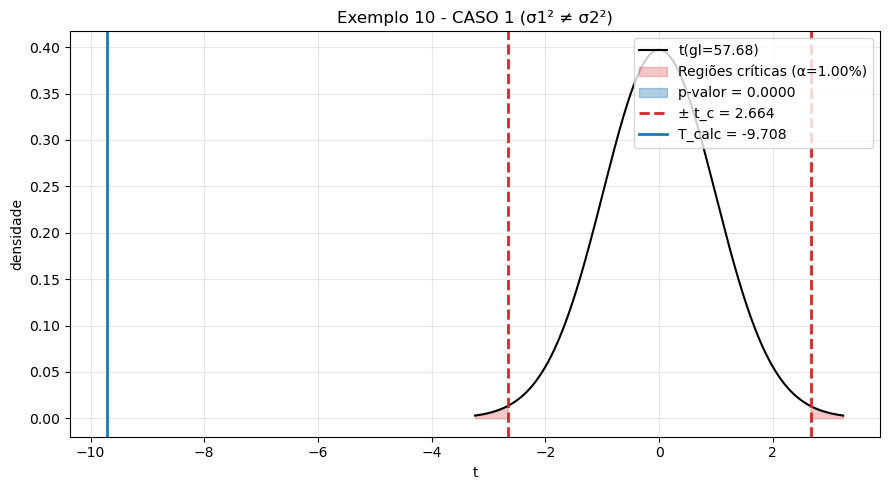

In [63]:
plot_t_bilateral(T_calc_1, gl_1, alpha, "Exemplo 10 - CASO 1 (σ1² ≠ σ2²)")

## CASO 2 — σ1² = σ2²

In [49]:
res10_c2 = teste_t(tipo="duas_independentes", alternativa="bilateral", alpha=alpha, x1=forn1, x2=forn2, caso=2)

print(f"T_calc = {res10_c2['T_calc']:.4f}, gl = {res10_c2['gl']:.0f}, t_c = {res10_c2['t_c']:.4f}, p-valor = {res10_c2['p_valor']:.4f}")
print("Decisão:", res10_c2["decisao"])

T_calc = -9.7084, gl = 58, t_c = 2.6633, p-valor = 0.0000
Decisão: Rejeitar H0


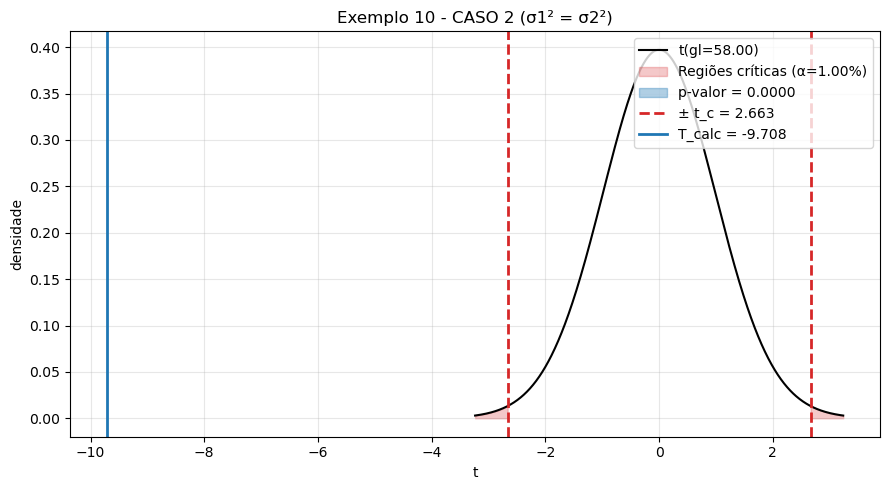

In [62]:
plot_t_bilateral(T_calc_2, gl_2, alpha, "Exemplo 10 - CASO 2 (σ1² = σ2²)")

# Exemplo 11
## Teste t de Student para duas amostras emparelhadas

Tempos de execução de 10 operadores antes e depois do treinamento.  
Definimos as diferenças emparelhadas d_i = X_antes,i − X_depois,i.

Hipóteses (unilateral à direita, α = 5%):
- H0: μ_d = 0  (não há redução no tempo)
- H1: μ_d > 0  (há redução: antes > depois)

Estatística do teste:
- T_calc = d̄ / (S_d / √n), com gl = n − 1
- Regra: rejeitar H0 se T_calc > t_{1−α, gl}

In [58]:
antes  = [3.2, 3.6, 3.4, 3.8, 3.4, 3.5, 3.7, 3.2, 3.5, 3.9]
depois = [3.0, 3.3, 3.5, 3.6, 3.4, 3.3, 3.4, 3.0, 3.2, 3.6]

In [60]:
res11 = teste_t(tipo="emparelhadas", alternativa="direita", alpha=0.05, x1=antes, x2=depois)

d = np.array(antes) - np.array(depois)

print(f"n = {len(d)}, d̄ = {d.mean():.4f}, S_d = {d.std(ddof=1):.4f}")
print(f"T_calc = {res11['T_calc']:.4f}, gl = {res11['gl']:.0f}, t_c_dir = {res11['t_c_dir']:.4f}, p-valor = {res11['p_valor']:.4f}")
print("Decisão:", res11["decisao"])

n = 10, d̄ = 0.1900, S_d = 0.1370
T_calc = 4.3846, gl = 9, t_c_dir = 1.8331, p-valor = 0.0009
Decisão: Rejeitar H0


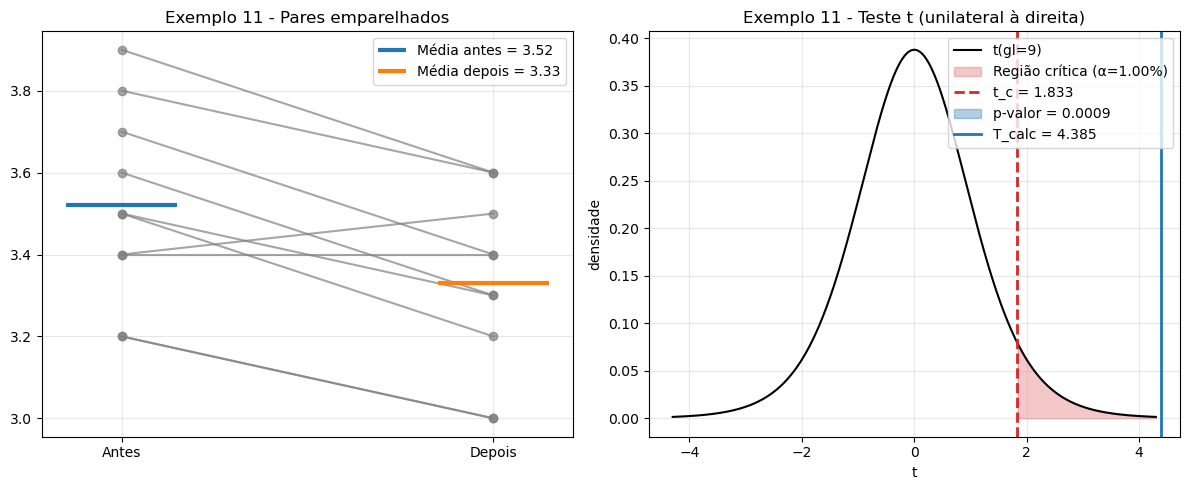

In [67]:
d = a - b
n = d.size

t_calc = float(res11['T_calc'])
df = int(res11['gl'])
alpha_plot = float(alpha if 'alpha' in globals() else 0.05)
t_crit = float(res11.get('t_c_dir', stats.t.ppf(1 - alpha_plot, df)))
p_valor = float(res11['p_valor'])


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Pares emparelhados
for i in range(n):
    ax[0].plot([1, 2], [a[i], b[i]], color='gray', alpha=0.7, marker='o')
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['Antes', 'Depois'])
ax[0].set_title('Exemplo 11 - Pares emparelhados')
ax[0].grid(alpha=0.3)
ax[0].hlines(a.mean(), 0.85, 1.15, colors='tab:blue', linewidth=3, label=f"Média antes = {a.mean():.2f}")
ax[0].hlines(b.mean(), 1.85, 2.15, colors='tab:orange', linewidth=3, label=f"Média depois = {b.mean():.2f}")
ax[0].legend(loc='best')

# Distribuição t
x = np.linspace(stats.t.ppf(0.001, df), stats.t.ppf(0.999, df), 1200)
y = stats.t.pdf(x, df)
ax[1].plot(x, y, color='black', lw=1.5, label=f"t(gl={df})")

mask_alpha = x >= t_crit
ax[1].fill_between(x[mask_alpha], 0, y[mask_alpha], color='tab:red', alpha=0.25, label=f"Região crítica (α={alpha_plot:.2%})")
ax[1].axvline(t_crit, color='tab:red', ls='--', lw=2, label=f"t_c = {t_crit:.3f}")

mask_p = x >= t_calc
ax[1].fill_between(x[mask_p], 0, y[mask_p], color='tab:blue', alpha=0.35, label=f"p-valor = {p_valor:.4f}")
ax[1].axvline(t_calc, color='tab:blue', lw=2, label=f"T_calc = {t_calc:.3f}")

ax[1].set_title('Exemplo 11 - Teste t (unilateral à direita)')
ax[1].set_xlabel('t')
ax[1].set_ylabel('densidade')
ax[1].grid(alpha=0.3)
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()